# Import and Reading Data

In [3]:
#Imports
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from operator import add
import ast

import rasterio
from glob import glob
from sklearn.model_selection import train_test_split

#U-Net
import tensorflow as tf
from segmentation_models import Unet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

#Deeplab
import torch
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision import models
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Segmentation Model Files
from ref_model_hypercol.models import UNetResNextHyperSE  # Adjust path as necessary
from ref_model_hypercol.blocks import *  # For EncoderBlock, DecoderBlockV4, etc.

#Evaluation
from sklearn.metrics import jaccard_score

#Self-written helpers
from helpers.general_helpers import *

In [4]:
#For reproducibility
seed = 42
# torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [5]:
# Labels as categories
label_names = [
    "Bad data",
    "Snow and Ice",
    "Wet ice and meltwater",
    "Freshwater",
    "Sediment",
    "Bedrock",
    "Vegetation",
    ]

#Location of test files
testimage_dir = './images/test/2023'
label_test = './labels/test'

# Get names of image and label files for test
testimage_files = sorted(glob(os.path.join(testimage_dir, '*.tif')))
testlabel_files = sorted(glob(os.path.join(label_test, '*.tif')))

## Data augmentation
Before training models with augmented data it would need to be generated. (Commented out due to time consumption)

In [7]:
#%run data_preprocessing.ipynb

## Reading Data

### Training data
Select one or multiple for training

In [13]:
# Choosing what data to load for training

# UNAUGMENTED DATA
data = np.load("cache/unchanged_data_2016.npz")
unaug_train_data = data['train_data']
unaug_train_labels = data['train_labels']
unaug_val_data = data['val_data']
unaug_val_labels = data['val_labels']

del data #For memory preservation

In [4]:
# AUGMENTED DATA
data = np.load("cache/augmented_data.npz")
train_data = data['train_data']
train_labels = data['train_labels']
val_data = data['val_data']
val_labels = data['val_labels']

del data #For memory preservation

In [4]:
# ALL YEARS DATA
data = np.load("cache/unchanged_data_all_years.npz")
train_data_all_years = data['train_data']
train_labels_all_years = data['train_labels']
val_data_all_years = data['val_data']
val_labels_all_years = data['val_labels']

del data #For memory preservation

### Testing data
Mandatory for evaluation

In [14]:
#TEST DATA
test_images = extract_channels(testimage_files)
test_labels = extract_labels(testlabel_files)

# Modelling

## U-Net

### Helpers/variables

In [ ]:
#Import unet helpers
from helpers.unet_helpers import *

In [1]:
#Variables
#Early stopping to avoid overfitting

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.005,
    patience=4,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

### Baseline

#### Training

In [14]:
#Since imagenet expects 3 colour channels we cannot preload weights
model_unet_base = Unet('resnet34', input_shape=(128, 128, 7), encoder_weights=None, classes = 7, activation = 'softmax')

In [15]:
#Code won't run without this
tf.compat.v1.reset_default_graph()

In [16]:
#Compile model with Adam optimiser
model_unet_base.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
    metrics=['accuracy']
)
callbacks = [early_stopping]
#Fit model
X_train = unaug_train_data
y_train = unaug_train_labels
X_val = unaug_val_data
y_val = unaug_val_labels
hist = model_unet_base.fit(X_train, y_train, batch_size = 20, epochs = 40, validation_data=(X_val, y_val), callbacks = callbacks)

Epoch 1/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.2126 - loss: 1.9691 - val_accuracy: 0.2320 - val_loss: 77.6899
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 56s 938ms/step - accuracy: 0.5310 - loss: 1.2872 - val_accuracy: 0.4375 - val_loss: 1.9059
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 56s 942ms/step - accuracy: 0.6783 - loss: 1.0190 - val_accuracy: 0.6506 - val_loss: 1.1229
Epoch 4/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 56s 927ms/step - accuracy: 0.7483 - loss: 0.8705 - val_accuracy: 0.7669 - val_loss: 0.8606
Epoch 5/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 56s 939ms/step - accuracy: 0.7657 - loss: 0.7778 - val_accuracy: 0.7752 - val_loss: 0.7565
Epoch 6/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 56s 936ms/step - accuracy: 0.7791 - loss: 0.7097 - val_accuracy: 0.7807 - val_loss: 0.6868
Epoch 7/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 56s 937ms/step - accuracy: 0.7841 - loss: 0.6688 - val_accuracy: 0.7901 - val_loss: 0.6286
Epoch 8/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 57s 945ms/step - accuracy: 0.7899 - loss: 0.6412 - val_accura

#### Evaluation
The cell right below can only be run if the model has been actually trained. Otherwise read the stats from the previous running from the given text file. The results of the evaluations commented out can be found in the report.

In [17]:
#Only run if trained the model

#Predict and transform back to how the data originally was
predictions = model_unet_base.predict(test_images)
prediction_values = array_to_int(predictions)

#Calculate accuracy
acc = np.sum(prediction_values == test_labels) / prediction_values.size
print(f"Accuracy of U-Net baseline model: {acc}")

# Calculate IOU
iou_metric = tf.keras.metrics.MeanIoU(num_classes=7)
iou_metric.update_state(test_labels, prediction_values)
iou_values = iou_metric.result().numpy()
print(f"Intersection over union of U-Net baseline model: {iou_values}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step
Accuracy of U-Net baseline model: 0.797657958984375
Intersection over union of U-Net baseline model: 0.4465283751487732


#### Plotting

In [18]:
#The logs of the trainings we have conducted are already written into log files, use those for plotting
train_accuracies, train_losses, val_accuracies, val_losses = read_unet_logs("training_logs/unet_base.txt")

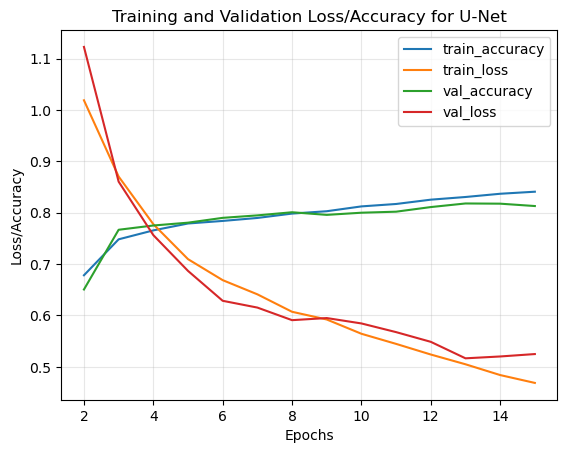

In [19]:
plot_lists = [train_accuracies, train_losses, val_accuracies, val_losses]
names = ["train_accuracy", "train_loss", "val_accuracy", "val_loss"]
plot_training(plot_lists, names, 2, 'Training and Validation Loss/Accuracy for U-Net', "Epochs", "Loss/Accuracy", 'plots/unet_all_baseline.png', have_grid = True)

### With modified data

#### Training

In [9]:
#Since imagenet expects 3 colour channels we cannot preload weights
model_unet = Unet('resnet34', input_shape=(128, 128, 7), encoder_weights=None, classes = 7, activation = 'softmax')

In [10]:
#Code won't run without this
tf.compat.v1.reset_default_graph()

In [21]:
#Compile model with Adam optimiser
model_unet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
    metrics=['accuracy']
)
callbacks = [early_stopping]
#Fit model
X_train = train_data
y_train = train_labels
X_val = val_data
y_val = val_labels
hist = model_unet.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data=(X_val, y_val), callbacks = callbacks)

#### Evaluation

In [ ]:
#Predict and transform back to how the data originally was
predictions = model_unet.predict(test_images)
prediction_values = array_to_int(predictions)

#Calculate accuracy
acc = np.sum(prediction_values == test_labels) / prediction_values.size
print(f"Accuracy of U-Net augmented data model: {acc}")

# Calculate IOU
iou_metric = tf.keras.metrics.MeanIoU(num_classes=7)
iou_metric.update_state(test_labels, prediction_values)
iou_values = iou_metric.result().numpy()
print(f"Intersection over union of U-Net augmented data model: {iou_values}")

#### Plotting

In [9]:
train_accuracies, train_losses, val_accuracies, val_losses = read_unet_logs("training_logs/unet_augmented.txt")

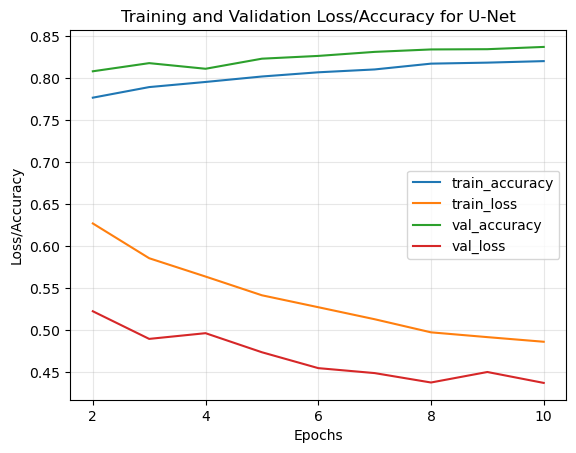

In [11]:
plot_lists = [train_accuracies, train_losses, val_accuracies, val_losses]
names = ["train_accuracy", "train_loss", "val_accuracy", "val_loss"]
plot_training(plot_lists, names, 2, 'Training and Validation Loss/Accuracy for U-Net', "Epochs", "Loss/Accuracy", 'plots/unet_all_augmented.png', have_grid = True)

### All training data

#### Training

In [12]:
#Since imagenet expects 3 colour channels we cannot preload weights
unet_all_data = Unet('resnet34', input_shape=(128, 128, 7), encoder_weights=None, classes = 7, activation = 'softmax')

In [13]:
#Code won't run without this
tf.compat.v1.reset_default_graph()

In [32]:
# For saving the best version of the model
checkpoint = ModelCheckpoint(
    filepath='models/unet_all_data_best_model.keras', 
    monitor='val_loss',       
    save_best_only=True,     
    save_weights_only=False,  
    mode='auto',             
    verbose=1                 
)

In [24]:
#Compile model with Adam optimiser
unet_all_data.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
    metrics=['accuracy']
)
callbacks = [early_stopping, checkpoint]
#Fit model
X_train = train_data_all_years
y_train = train_labels_all_years
X_val = val_data_all_years
y_val = val_labels_all_years
hist = unet_all_data.fit(X_train, y_train, batch_size = 16, epochs = 50, validation_data=(X_val, y_val), callbacks = callbacks)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.8202 - loss: 0.5045
Epoch 1: val_loss improved from inf to 0.51046, saving model to unet_all_data_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 199s 763ms/step - accuracy: 0.8202 - loss: 0.5044 - val_accuracy: 0.8178 - val_loss: 0.5105
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.8273 - loss: 0.4818
Epoch 2: val_loss did not improve from 0.51046
225/225 ━━━━━━━━━━━━━━━━━━━━ 165s 735ms/step - accuracy: 0.8273 - loss: 0.4818 - val_accuracy: 0.8066 - val_loss: 0.5381
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.8253 - loss: 0.4834
Epoch 3: val_loss improved from 0.51046 to 0.49228, saving model to unet_all_data_best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 165s 732ms/step - accuracy: 0.8253 - loss: 0.4833 - val_accuracy: 0.8238 - val_loss: 0.4923
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.8353 - loss: 0.4541
Epoch 4: val_loss did not improve from 0.492

#### Evaluation

In [28]:
#Load best model
best_model = load_model('models/unet_all_data_best_model.keras')

#Predict and transform back to how the data originally was
predictions = best_model.predict(test_images)
prediction_values = array_to_int(predictions)

#Calculate accuracy
acc = np.sum(prediction_values == test_labels) / prediction_values.size
print(f"Accuracy of hypercolumns all data model: {acc}")

# Calculate IOU
iou_metric = tf.keras.metrics.MeanIoU(num_classes=7)
iou_metric.update_state(test_labels, prediction_values)
iou_values = iou_metric.result().numpy()
print(f"Intersection over union of hypercolumns all data model: {iou_values}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 421ms/step
Accuracy of U-Net all data model: 0.8019288330078125
Intersection over union of U-Net all data model: 0.4663527309894562


In [34]:
train_accuracies, train_losses, val_accuracies, val_losses = read_unet_logs("training_logs/unet_all_data.txt")

#### Plotting

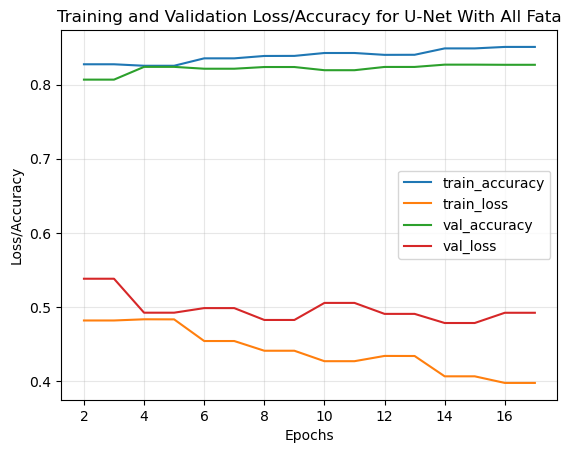

In [36]:
plot_lists = [train_accuracies, train_losses, val_accuracies, val_losses]
names = ["train_accuracy", "train_loss", "val_accuracy", "val_loss"]
plot_training(plot_lists, names, 2, 'Training and Validation Loss/Accuracy for U-Net With All Data', "Epochs", "Loss/Accuracy", 'plots/unet_all_all_data.png', have_grid = True)

## Deeplab

### Functions

In [ ]:
#Deeplab helpers
from helpers.deeplab_helpers import *

In [8]:
# Main training script for deeplab. Takes as input the model, the dataloaders, the optimizer, number of epochs,
#a patience counter and a path where to save the best model.
# Outputs 6 lists with train_accuracies, train_losses, val_accuracies, val_losses, train_ious, val_ious
def training_deeplab(model, train_loader, val_loader, nr_epochs, patience, model_savefile):

    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses = []
    train_accuracies = []
    train_ious = []
    val_losses = []
    val_accuracies = []
    val_ious = []
    
    for epoch in range(nr_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_accuracy = 0.0
        running_ious = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]

        #Training
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
    
            outputs = model(inputs)['out'] # Forward pass
            loss = criterion(outputs, targets) # Calculate the loss
            optimizer.zero_grad() # Zero the parameter gradients 
            loss.backward() # Backward pass
            optimizer.step() # Update the weights
    
            #Calculate loss and accuracy for batch
            running_loss += loss.item()
            running_accuracy += calculate_accuracy(outputs, targets)
            running_ious = list(map(add, running_ious, calculate_IOU(outputs, targets, 7)))

        train_loss = running_loss / len(train_loader)
        train_accuracy = running_accuracy / len(train_loader)
        train_iou = list(map(lambda x: round(x/len(train_loader), 4), running_ious))

        # Validation
        model.eval() #Set model to validation mode
        running_val_loss = 0.0
        running_val_accuracy = 0.0
        running_val_ious = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)['out']
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                running_val_accuracy += calculate_accuracy(outputs, targets)
                running_val_ious = list(map(add, running_val_ious, calculate_IOU(outputs, targets, 7)))

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = running_val_accuracy / len(val_loader)
        val_iou = list(map(lambda x: round(x/len(val_loader), 4), running_val_ious))

        #Log the accuracies and losses of the epoch
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_ious.append(train_iou)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_ious.append(val_iou)

        print(f"""Epoch [{epoch+1}/{nr_epochs}]; Train Loss: {round(train_loss, 4)};Val Loss: {round(val_loss, 4)}; """
        f"""Train Accuracy: {round(train_accuracy, 4)}; Val Accuracy: {round(val_accuracy, 4)}; """
        f"""Train IOU: {train_iou}; Val IOU: {val_iou}""")

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), model_savefile)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break


### Transforming data

In [9]:
#Change test data input shape to how torch likes it
test_images_torch = torch.from_numpy(test_images)
test_images_torch = test_images_torch.permute(0, 3, 1, 2)
test_images_torch = test_images_torch.to(torch.float32)


test_lable_onehot = one_hot_labels(test_labels, 7)
test_labels_torch = torch.from_numpy(test_lable_onehot)
test_labels_torch = test_labels_torch.permute(0, 3, 1, 2)
test_labels_torch = test_labels_torch.to(torch.float32)

In [10]:
#Dataset construction
class SegmentationDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        return image, label

In [11]:
#Create test dataloader
test_dataset = SegmentationDataset(test_images_torch, test_labels_torch)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Baseline

In [132]:
#Change input shape to how torch likes it
#Train
unaug_train_torch = torch.from_numpy(unaug_train_data)
unaug_train_torch = unaug_train_torch.permute(0, 3, 1, 2)
unaug_train_torch = unaug_train_torch.to(torch.float32)

unaug_train_labels_torch = torch.from_numpy(unaug_train_labels)
unaug_train_labels_torch = unaug_train_labels_torch.permute(0, 3, 1, 2)
unaug_train_labels_torch = unaug_train_labels_torch.float()

#Validation
unaug_val_torch = torch.from_numpy(unaug_val_data)
unaug_val_torch = unaug_val_torch.permute(0, 3, 1, 2)
unaug_val_torch = unaug_val_torch.to(torch.float32)

unaug_val_labels_torch = torch.from_numpy(unaug_val_labels)
unaug_val_labels_torch = unaug_val_labels_torch.permute(0, 3, 1, 2)
unaug_val_labels_torch = unaug_val_labels_torch.float()

In [133]:
# Create the dataset and dataloaders
train_dataset = SegmentationDataset(unaug_train_torch, unaug_train_labels_torch)
val_dataset = SegmentationDataset(unaug_val_torch, unaug_val_labels_torch)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#### Training

In [134]:
# Model
model_deep_base = models.segmentation.deeplabv3_resnet50(weights=None)

#Change input and output layers to suit our needs
model_deep_base.backbone.conv1 = nn.Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_deep_base.classifier[4] = nn.Conv2d(256, 7, kernel_size=(1, 1))  # 7 output channels

#Give model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_deep_base = model_deep_base.to(device) 

In [135]:
# Optimizer
optimizer = optim.Adam(model_deep_base.parameters(), lr=1e-4)
#Loss
criterion = nn.CrossEntropyLoss()

In [136]:
#Patience for early stopping
patience = 5
best_val_loss = float('inf')
patience_counter = 0

In [137]:
training_deeplab(model_deep_base, train_loader, val_loader, 30, 3, "models/deeplab_best_base.pth")

Epoch [1/30]; Train Loss: 1.018;Val Loss: 0.7989; Train Accuracy: 0.6628; Val Accuracy: 0.7157; Train IOU: [0.3726, 0.7572, 0.2041, 0.1323, 0.0066, 0.5148, 0.4816]; Val IOU: [0.4524, 0.8366, 0.3287, 0.2262, 0.0522, 0.5138, 0.5536]
Epoch [2/30]; Train Loss: 0.749;Val Loss: 0.691; Train Accuracy: 0.7458; Val Accuracy: 0.7499; Train IOU: [0.4964, 0.8407, 0.308, 0.319, 0.0545, 0.5822, 0.5757]; Val IOU: [0.4599, 0.8698, 0.4209, 0.3187, 0.0266, 0.5979, 0.5494]
Epoch [3/30]; Train Loss: 0.697;Val Loss: 0.6365; Train Accuracy: 0.7595; Val Accuracy: 0.771; Train IOU: [0.5042, 0.8608, 0.3736, 0.3608, 0.0769, 0.5905, 0.5958]; Val IOU: [0.5072, 0.8658, 0.4517, 0.3366, 0.019, 0.6164, 0.6126]
Epoch [4/30]; Train Loss: 0.6618;Val Loss: 0.7515; Train Accuracy: 0.7688; Val Accuracy: 0.7237; Train IOU: [0.5453, 0.8395, 0.3832, 0.3721, 0.0949, 0.6078, 0.62]; Val IOU: [0.4345, 0.8177, 0.4327, 0.346, 0.1063, 0.4821, 0.5806]
Epoch [5/30]; Train Loss: 0.6503;Val Loss: 0.6343; Train Accuracy: 0.7712; Val Accu

#### Evaluation
The cell right below can only be run if the model has been actually trained. Otherwise read the stats from the previous running from the given text file. The results of the evaluations commented out can be found in the report.

In [138]:
#Only run if trained the model

#Load the best model and do evaluation on it
model_best = models.segmentation.deeplabv3_resnet50(weights=None)
model_best.backbone.conv1 = nn.Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_best.classifier[4] = nn.Conv2d(256, 7, kernel_size=(1, 1))
model_best.load_state_dict(torch.load("models/deeplab_best_base.pth", weights_only=True))
model_best = model_best.to(device)
model_best.eval()

#Make predictions

running_test_accuracy = 0.0
running_test_IOU = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_best(inputs)['out']
        running_test_accuracy += calculate_accuracy(outputs, targets)
        running_test_IOU = list(map(add, running_test_IOU, calculate_IOU(outputs, targets, 7)))
        
test_accuracy = running_test_accuracy / len(test_loader)
test_iou = list(map(lambda x: round(x/len(test_loader), 4), running_test_IOU))
print(f"Accuracy on test set: {test_accuracy}")
print(f"IOU on test set: {test_iou}")

Accuracy on test set: 0.7982503175735474
IOU on test set: [0.3401, 0.3827, 0.2799, 0.2986, 0.1851, 0.1506, 0.8037]


#### Plotting

In [9]:
# Read the training logs of previous training
train_accuracies, train_losses, train_ious, val_accuracies, val_losses, val_ious = read_deeplab_logs("training_logs/deeplab_base.txt")

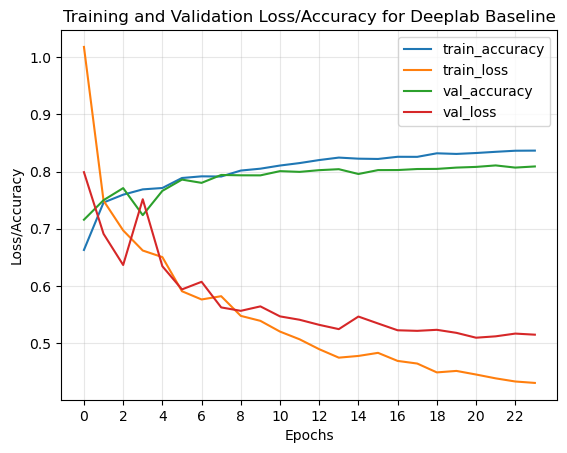

In [11]:
plot_lists = [train_accuracies, train_losses, val_accuracies, val_losses]
names = ["train_accuracy", "train_loss", "val_accuracy", "val_loss"]
plot_training(plot_lists, names, 0, 'Training and Validation Loss/Accuracy for Deeplab Baseline', "Epochs", "Loss/Accuracy", 'plots/deeplab_all_baseline.png', have_grid = True)

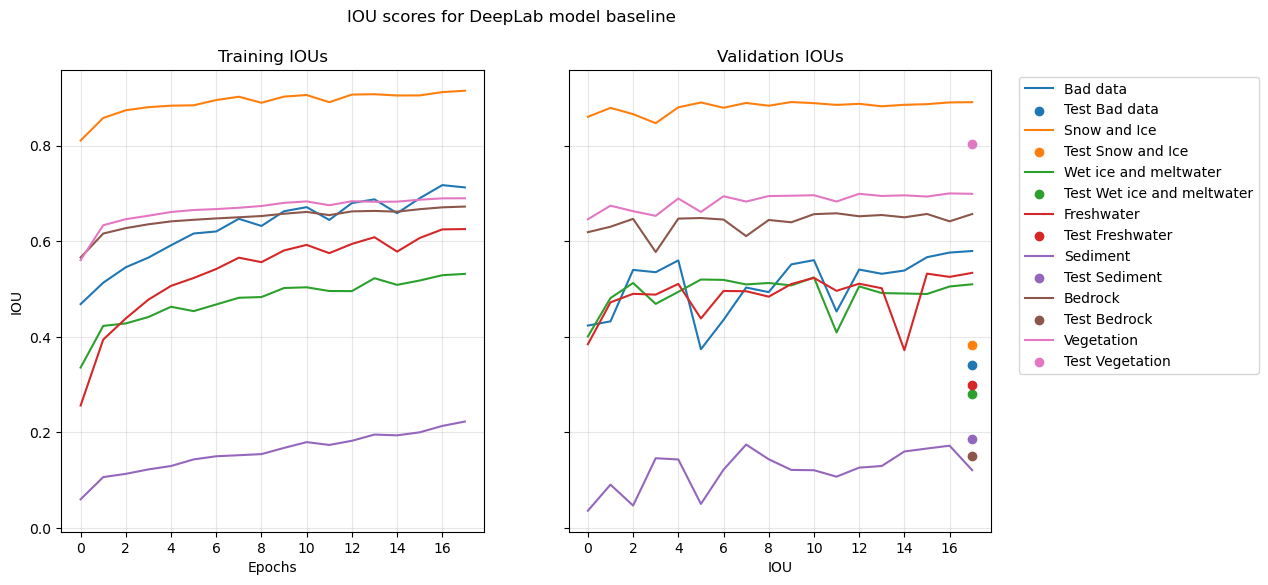

In [18]:
train_ious_T = [list(row) for row in zip(*train_ious)]
val_ious_T = [list(row) for row in zip(*val_ious)]
names = label_names
test_points = [0.3401, 0.3827, 0.2799, 0.2986, 0.1851, 0.1506, 0.8037]
plot_iou(train_ious_T, val_ious_T, names,"IOU scores for DeepLab model baseline", 0, 'plots/deeplab_iou_baseline.png', have_grid = True, test_ious=test_points)

As seen on this plot, the validation iou is very comparable with the training one

### Augmented Data

In [142]:
#Change input shape to how torch likes it
#Train
train_torch = torch.from_numpy(train_data)
train_torch = train_torch.permute(0, 3, 1, 2)
train_torch = train_torch.to(torch.float32)

train_labels_torch = torch.from_numpy(train_labels)
train_labels_torch = train_labels_torch.permute(0, 3, 1, 2)
train_labels_torch = train_labels_torch.float()

#Validation
val_torch = torch.from_numpy(val_data)
val_torch = val_torch.permute(0, 3, 1, 2)
val_torch = val_torch.to(torch.float32)

val_labels_torch = torch.from_numpy(val_labels)
val_labels_torch = val_labels_torch.permute(0, 3, 1, 2)
val_labels_torch = val_labels_torch.float()

In [143]:
# Create the dataset and dataloaders
train_dataset = SegmentationDataset(train_torch, train_labels_torch)
val_dataset = SegmentationDataset(val_torch, val_labels_torch)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#### Training

In [144]:
# Model
model_deep = models.segmentation.deeplabv3_resnet50(weights=None)

#Change input and output layers to suit our needs
model_deep.backbone.conv1 = nn.Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_deep.classifier[4] = nn.Conv2d(256, 7, kernel_size=(1, 1))  # 7 output channels

#Give model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_deep = model_deep.to(device) 

In [145]:
# Optimizer
optimizer = optim.Adam(model_deep.parameters(), lr=1e-4)
#Loss
criterion = nn.CrossEntropyLoss()

In [146]:
#Patience for early stopping
patience = 5

In [147]:
training_deeplab(model_deep, train_loader, val_loader, 40, patience, "models/deeplab_best_aug.pth")

Epoch [1/40]; Train Loss: 0.7929;Val Loss: 0.6224; Train Accuracy: 0.7284; Val Accuracy: 0.7742; Train IOU: [0.4683, 0.8108, 0.3355, 0.256, 0.0597, 0.5659, 0.5606]; Val IOU: [0.4234, 0.8604, 0.4006, 0.3844, 0.0358, 0.6189, 0.6459]
Epoch [2/40]; Train Loss: 0.6231;Val Loss: 0.5732; Train Accuracy: 0.7759; Val Accuracy: 0.7913; Train IOU: [0.5131, 0.858, 0.4227, 0.394, 0.1062, 0.616, 0.6334]; Val IOU: [0.4322, 0.8791, 0.481, 0.472, 0.0904, 0.6303, 0.6744]
Epoch [3/40]; Train Loss: 0.5801;Val Loss: 0.5538; Train Accuracy: 0.7876; Val Accuracy: 0.8013; Train IOU: [0.5455, 0.8741, 0.4279, 0.4384, 0.113, 0.6274, 0.6461]; Val IOU: [0.5399, 0.866, 0.5125, 0.4898, 0.0466, 0.6467, 0.6628]
Epoch [4/40]; Train Loss: 0.5537;Val Loss: 0.5922; Train Accuracy: 0.7958; Val Accuracy: 0.7792; Train IOU: [0.5657, 0.8806, 0.4413, 0.4777, 0.1223, 0.6354, 0.6534]; Val IOU: [0.5351, 0.8471, 0.4688, 0.4882, 0.1457, 0.5774, 0.6531]
Epoch [5/40]; Train Loss: 0.5333;Val Loss: 0.5148; Train Accuracy: 0.8034; Val A

#### Evaluation

In [149]:
#Load the best model and do evaluation on it

model_best = models.segmentation.deeplabv3_resnet50(weights=None)
model_best.backbone.conv1 = nn.Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_best.classifier[4] = nn.Conv2d(256, 7, kernel_size=(1, 1))
model_best.load_state_dict(torch.load("models/deeplab_best_aug.pth", weights_only=True))
model_best = model_best.to(device)
model_best.eval()

#Make predictions

running_test_accuracy = 0.0
running_test_IOU = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_best(inputs)['out']
        running_test_accuracy += calculate_accuracy(outputs, targets)
        running_test_IOU = list(map(add, running_test_IOU, calculate_IOU(outputs, targets, 7)))
        
test_accuracy = running_test_accuracy / len(test_loader)
test_iou = list(map(lambda x: round(x/len(test_loader), 4), running_test_IOU))
print(f"Accuracy on test set: {test_accuracy}")
print(f"IOU on test set: {test_iou}")

Accuracy on test set: 0.7918317317962646
IOU on test set: [0.3374, 0.395, 0.2363, 0.2554, 0.1527, 0.1303, 0.8042]


#### Plotting

In [25]:
# Read the training logs of previous training
train_accuracies, train_losses, train_ious, val_accuracies, val_losses, val_ious = read_deeplab_logs("training_logs/deeplab_aug.txt")

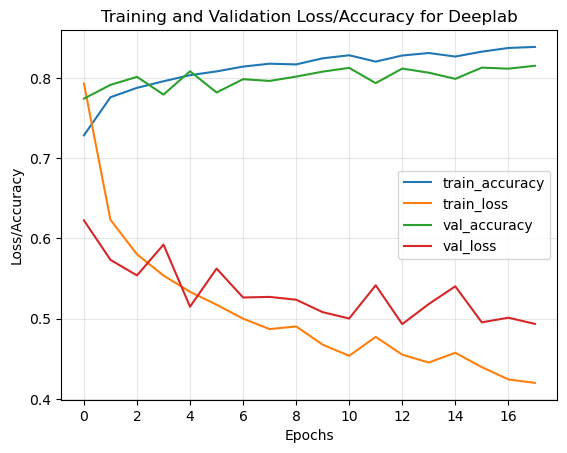

In [26]:
plot_lists = [train_accuracies, train_losses, val_accuracies, val_losses]
names = ["train_accuracy", "train_loss", "val_accuracy", "val_loss"]
plot_training(plot_lists, names, 0, 'Training and Validation Loss/Accuracy for Deeplab', "Epochs", "Loss/Accuracy", 'plots/deeplab_all_aug.png', have_grid = True)

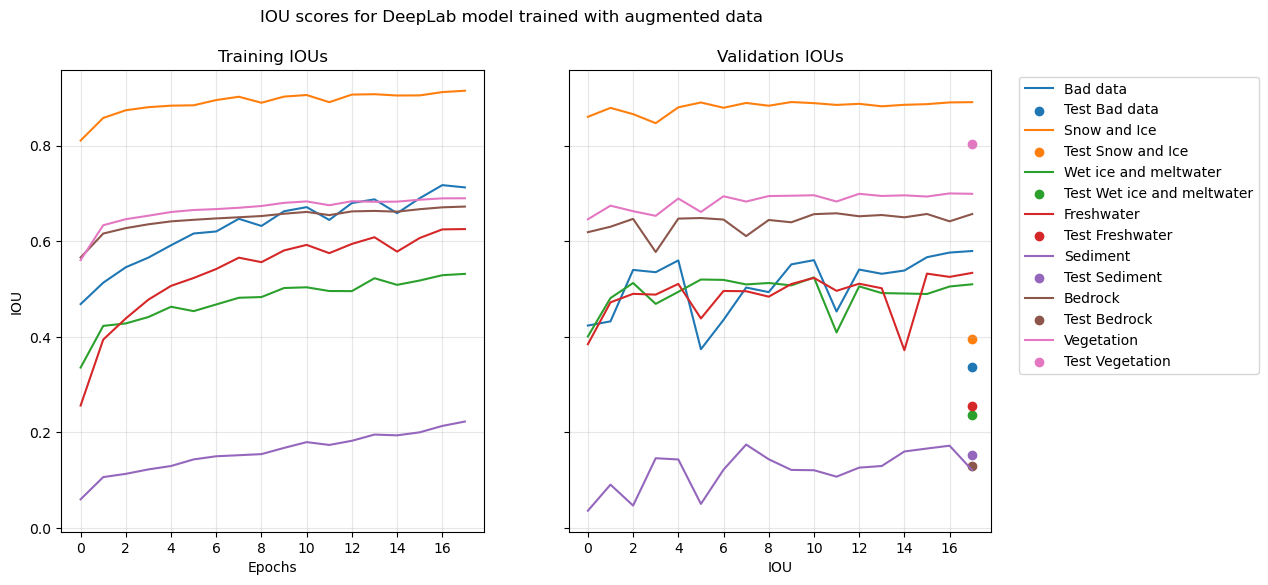

In [27]:
train_ious_T = [list(row) for row in zip(*train_ious)]
val_ious_T = [list(row) for row in zip(*val_ious)]
names = label_names
test_points = [0.3374, 0.395, 0.2363, 0.2554, 0.1527, 0.1303, 0.8042]
plot_iou(train_ious_T, val_ious_T, names, "IOU scores for DeepLab model trained with augmented data", 0, 'plots/deeplab_iou_augmented.png', have_grid = True, test_ious=test_points)

As seen on this plot, the validation performs very similarly to the training data. However, the test is a different story. This may be due to the landscape changing enough where most labels are harder to predict but vegetation is easier

### All data

In [12]:
#Change input shape to how torch likes it
#Train
train_torch = torch.from_numpy(train_data_all_years)
train_torch = train_torch.permute(0, 3, 1, 2)
train_torch = train_torch.to(torch.float32)

train_labels_torch = torch.from_numpy(train_labels_all_years)
train_labels_torch = train_labels_torch.permute(0, 3, 1, 2)
train_labels_torch = train_labels_torch.float()

#Validation
val_torch = torch.from_numpy(val_data_all_years)
val_torch = val_torch.permute(0, 3, 1, 2)
val_torch = val_torch.to(torch.float32)

val_labels_torch = torch.from_numpy(val_labels_all_years)
val_labels_torch = val_labels_torch.permute(0, 3, 1, 2)
val_labels_torch = val_labels_torch.float()

In [13]:
# Create the dataset and dataloaders
train_dataset = SegmentationDataset(train_torch, train_labels_torch)
val_dataset = SegmentationDataset(val_torch, val_labels_torch)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#### Training

In [14]:
# Model
deeplab_all_data = models.segmentation.deeplabv3_resnet50(weights=None)

#Change input and output layers to suit our needs
deeplab_all_data.backbone.conv1 = nn.Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
deeplab_all_data.classifier[4] = nn.Conv2d(256, 7, kernel_size=(1, 1))  # 7 output channels

#Give model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab_all_data = deeplab_all_data.to(device) 

In [16]:
# Optimizer
optimizer = optim.Adam(deeplab_all_data.parameters(), lr=1e-4)
#Loss
criterion = nn.CrossEntropyLoss()
#Patience for early stopping
patience = 5

In [17]:
training_deeplab(deeplab_all_data, train_loader, val_loader, 40, patience, "models/deeplab_best_all_data.pth")

Epoch [1/40]; Train Loss: 0.8365;Val Loss: 0.709; Train Accuracy: 0.717; Val Accuracy: 0.7393; Train IOU: [0.4632, 0.812, 0.3125, 0.2315, 0.0365, 0.5545, 0.5414]; Val IOU: [0.4673, 0.8376, 0.426, 0.4014, 0.0795, 0.5014, 0.6003]
Epoch [2/40]; Train Loss: 0.6634;Val Loss: 0.6357; Train Accuracy: 0.7671; Val Accuracy: 0.7733; Train IOU: [0.512, 0.84, 0.4006, 0.3948, 0.08, 0.6045, 0.6176]; Val IOU: [0.4598, 0.8586, 0.4095, 0.4605, 0.0689, 0.6244, 0.6451]
Epoch [3/40]; Train Loss: 0.5938;Val Loss: 0.6179; Train Accuracy: 0.7861; Val Accuracy: 0.7728; Train IOU: [0.5595, 0.8725, 0.4132, 0.4588, 0.1033, 0.62, 0.6366]; Val IOU: [0.4892, 0.8668, 0.3776, 0.3905, 0.0441, 0.6168, 0.6698]
Epoch [4/40]; Train Loss: 0.5466;Val Loss: 0.5757; Train Accuracy: 0.8014; Val Accuracy: 0.7889; Train IOU: [0.6123, 0.8833, 0.4694, 0.5238, 0.11, 0.6311, 0.6493]; Val IOU: [0.5336, 0.8784, 0.4646, 0.4449, 0.1228, 0.6344, 0.6515]
Epoch [5/40]; Train Loss: 0.5419;Val Loss: 0.5975; Train Accuracy: 0.8034; Val Accura

#### Evaluation

In [18]:
#Load the best model and do evaluation on it
model_best = models.segmentation.deeplabv3_resnet50(weights=None)
model_best.backbone.conv1 = nn.Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_best.classifier[4] = nn.Conv2d(256, 7, kernel_size=(1, 1))
model_best.load_state_dict(torch.load("models/deeplab_best_all_data.pth", weights_only=True))
model_best = model_best.to(device)
model_best.eval()

#Make predictions

running_test_accuracy = 0.0
running_test_IOU = [0.0,0.0,0.0,0.0,0.0,0.0,0.0]
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_best(inputs)['out']
        running_test_accuracy += calculate_accuracy(outputs, targets)
        running_test_IOU = list(map(add, running_test_IOU, calculate_IOU(outputs, targets, 7)))
        
test_accuracy = running_test_accuracy / len(test_loader)
test_iou = list(map(lambda x: round(x/len(test_loader), 4), running_test_IOU))
print(f"Accuracy on test set: {test_accuracy}")
print(f"IOU on test set: {test_iou}")

Accuracy on test set: 0.8029847145080566
IOU on test set: [0.3288, 0.3765, 0.2682, 0.336, 0.141, 0.2047, 0.8174]


#### Plotting

In [19]:
# Read the training logs of previous training
train_accuracies, train_losses, train_ious, val_accuracies, val_losses, val_ious = read_deeplab_logs("training_logs/deeplab_all_data.txt")

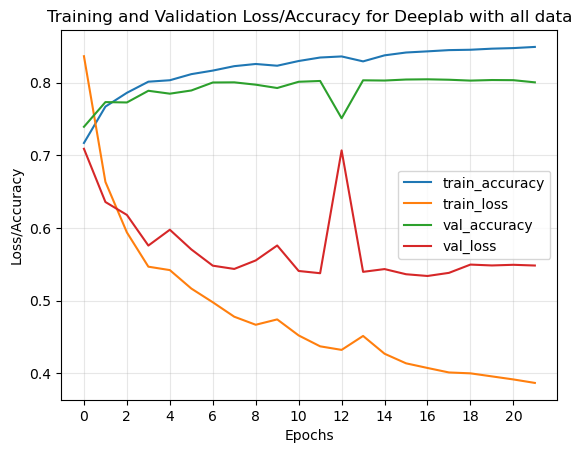

In [20]:
plot_lists = [train_accuracies, train_losses, val_accuracies, val_losses]
names = ["train_accuracy", "train_loss", "val_accuracy", "val_loss"]
plot_training(plot_lists, names, 0, 'Training and Validation Loss/Accuracy for Deeplab with all data', "Epochs", "Loss/Accuracy", 'plots/deeplab_all_all_data.png', have_grid = True)

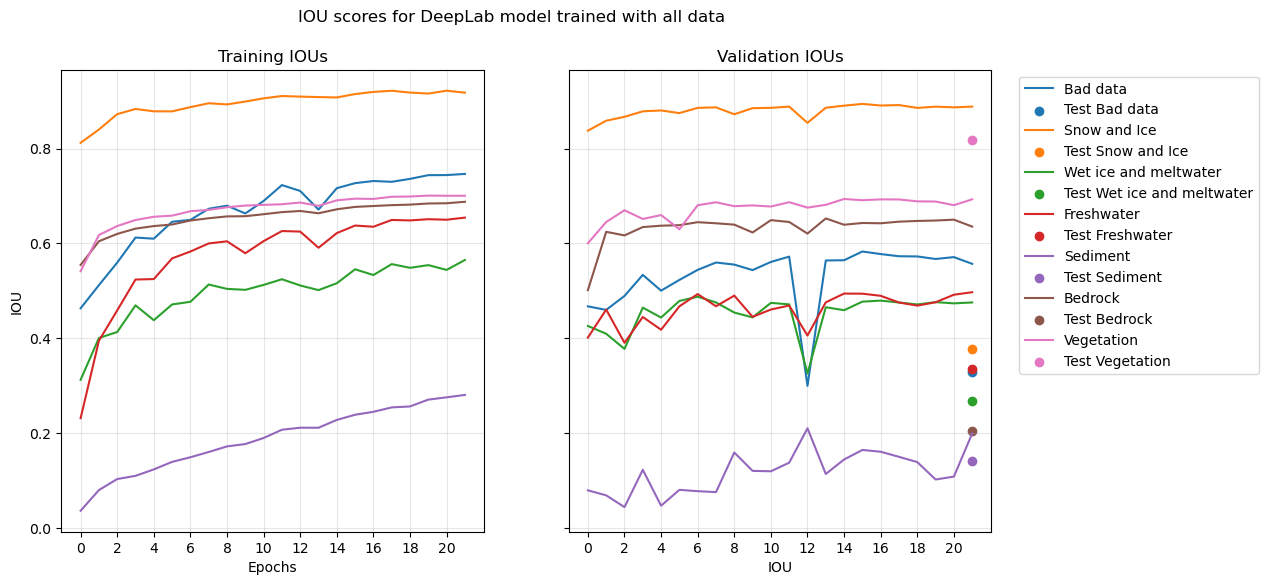

In [24]:
train_ious_T = [list(row) for row in zip(*train_ious)]
val_ious_T = [list(row) for row in zip(*val_ious)]
names = label_names
test_points = [0.3288, 0.3765, 0.2682, 0.336, 0.141, 0.2047, 0.8174]
plot_iou(train_ious_T, val_ious_T, names, "IOU scores for DeepLab model trained with all data", 0, 'plots/deeplab_iou_all_data.png', have_grid = True, test_ious=test_points)

## Hypercolumns

#### Helpers

In [8]:
#Hypercolumn helpers
from helpers.hypercolumn_helpers import *

In [9]:
# Convert your dataset into PyTorch-friendly format using a custom Dataset class
class SegmentationDataset(Dataset):
    """
    Custom PyTorch Dataset for Semantic Segmentation.
    """
    def __init__(self, images, labels):
        self.images = torch.tensor(images).float()  # Convert images to tensors
        self.labels = torch.tensor(labels).long()   # Convert labels to tensors

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Transpose image to match PyTorch CHW format
        image = image.permute(2, 0, 1)  # From HWC to CHW format

        # Convert one-hot encoded labels to class indices
        label = torch.argmax(label, dim=-1)  # Shape becomes [height, width]

        return image, label

#### Training function

In [10]:
def train_hypercol(model, train_loader, val_loader, savefile, folder):
    
    # Clear the metric files before training
    with open(folder + "train_losses.txt", "w") as f:
        pass
    with open(folder + "train_accuracies.txt", "w") as f:
        pass
    with open(folder + "val_losses.txt", "w") as f:
        pass
    with open(folder + "val_accuracies.txt", "w") as f:
        pass

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class segmentation
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with default learning rate
    
    # Initialize lists to store metrics for later analysis
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # Training loop
    num_epochs = 20
    best_val_loss = float('inf')  # Track the best validation loss
    
    for epoch in range(1, num_epochs + 1):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        correct_train = 0
        total_train = 0
    
        print(f"\nEpoch {epoch}/{num_epochs}")
        print("-" * 40)
    
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
    
            train_loss += loss.item()
            preds = outputs.argmax(dim=1)  # Get class predictions
            correct_train += (preds == labels).sum().item()
            total_train += labels.numel()
    
            # Batch accuracy
            batch_accuracy = (preds == labels).sum().item() / labels.numel()
    
            # Print batch-level progress with accuracy
            if (batch_idx + 1) % 10 == 0:
                print(
                    f"Batch [{batch_idx+1}/{len(train_loader)}]: "
                    f"Loss = {loss.item():.4f}, Accuracy = {batch_accuracy:.4f}"
                )
    
        # Calculate average training loss and accuracy
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
    
        # Save training metrics
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
    
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
    
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)  # Get class predictions
                correct_val += (preds == labels).sum().item()
                total_val += labels.numel()
    
                # Batch accuracy for validation
                val_batch_accuracy = (preds == labels).sum().item() / labels.numel()
    
                # Print validation progress with accuracy
                if (batch_idx + 1) % 5 == 0:
                    print(
                        f"Validation Batch [{batch_idx+1}/{len(val_loader)}]: "
                        f"Loss = {loss.item():.4f}, Accuracy = {val_batch_accuracy:.4f}"
                    )
    
        # Calculate average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
    
        # Save validation metrics
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
    
        # Save metrics to .txt files
        with open(folder + "train_losses.txt", "a") as f:
            f.write(f"{avg_train_loss}\n")
        with open(folder + "train_accuracies.txt", "a") as f:
            f.write(f"{train_accuracy}\n")
        with open(folder + "val_losses.txt", "a") as f:
            f.write(f"{avg_val_loss}\n")
        with open(folder + "val_accuracies.txt", "a") as f:
            f.write(f"{val_accuracy}\n")
    
        # Print epoch-level summary
        print(
            f"Epoch Summary: "
            f"Train Loss = {avg_train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, "
            f"Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}"
        )
    
        # Save the model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), savefile)
            print("Best model saved!")

#### Evaluation func

In [28]:
def evaluate_hypercol(model_name, testimage_files, testlabel_files, device):
    # Load the best model
    model = UNetResNextHyperSE(encoder_depth=50, num_classes=7, num_filters=32, dropout_2d=0.2, is_deconv=True)
    model.load_state_dict(torch.load(model_name,weights_only=False))
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    # Prepare test data
    test_images = extract_channels(testimage_files)  # Already implemented function
    test_labels = extract_labels(testlabel_files)    # Already implemented function
    
    # Convert test data to PyTorch tensors
    test_images = torch.tensor(test_images).float().permute(0, 3, 1, 2)  # HWC to CHW
    test_labels = torch.tensor(test_labels).long()
    
    # Move data to the appropriate device
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)
    
    # Predictions
    with torch.no_grad():
        outputs = model(test_images)  # Forward pass
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()  # Convert predictions to numpy array
        test_labels = test_labels.cpu().numpy()  # Convert labels to numpy array
    
    # Calculate accuracy
    accuracy = np.sum(predictions == test_labels) / test_labels.size
    print(f"Accuracy of the model on test images: {accuracy:.4f}")
    
    # Calculate IoU (Intersection over Union) for each class
    iou_values = []
    for class_id in range(7):  # Loop over all classes
        iou = jaccard_score(
            test_labels.flatten() == class_id,  # Flatten and binarize labels
            predictions.flatten() == class_id,  # Flatten and binarize predictions
            average="binary"
        )
        iou_values.append(iou)
    
    # Print IoU for each class and mean IoU
    for idx, iou_value in enumerate(iou_values):
        print(f"IoU value for {label_names[idx]}: {round(iou_value, 4)}")

    mean_iou = np.mean(iou_values)
    print(f"Mean IoU of the model on test images: {mean_iou:.4f}")

### Baseline

#### Training

In [11]:
# model.py file was modified form original; before: pretraine='imagenet', after: pretrained=None

# Define the UNetResNextHyperSE model
num_classes = 7  # number of segmentation labels
input_channels = 7  # Number of channels in the input data

# Instantiate the model
model = UNetResNextHyperSE(
    encoder_depth=50,  # Use SE-ResNeXt50 as the backbone
    num_classes=num_classes,
    num_filters=32,
    is_deconv=True,
    dropout_2d=0.2
)

# Transfer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model successfully instantiated and moved to:", device)

Model successfully instantiated and moved to: cpu


In [15]:
#-------------unaugmented data----------------
# Create training and validation datasets, use: unaugmented train and validation data
train_dataset = SegmentationDataset(unaug_train_data, unaug_train_labels)
val_dataset = SegmentationDataset(unaug_val_data, unaug_val_labels)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
#--------------------------------------------

print("DataLoader successfully created.")

DataLoader successfully created.


In [8]:
train_hypercol(model, train_loader, val_loader, "models/hypercol_nonaug_model.pth", "best_model_&_txt_hypercol/unaugmented_data_perfomraces/")
print("\nTraining complete!")


Epoch 1/20
----------------------------------------
Batch [10/225]: Loss = 1.2084, Accuracy = 0.5690
Batch [20/225]: Loss = 1.2134, Accuracy = 0.5778
Batch [30/225]: Loss = 1.0362, Accuracy = 0.6867
Batch [40/225]: Loss = 0.9570, Accuracy = 0.6664
Batch [50/225]: Loss = 0.8579, Accuracy = 0.6830
Batch [60/225]: Loss = 0.7563, Accuracy = 0.7389
Batch [70/225]: Loss = 0.4562, Accuracy = 0.8641
Batch [80/225]: Loss = 0.7969, Accuracy = 0.7352
Batch [90/225]: Loss = 0.4968, Accuracy = 0.8273
Batch [100/225]: Loss = 0.6667, Accuracy = 0.7535
Batch [110/225]: Loss = 0.6776, Accuracy = 0.7011
Batch [120/225]: Loss = 0.6960, Accuracy = 0.7361
Batch [130/225]: Loss = 0.7488, Accuracy = 0.7291
Batch [140/225]: Loss = 0.6862, Accuracy = 0.7428
Batch [150/225]: Loss = 0.6759, Accuracy = 0.7590
Batch [160/225]: Loss = 0.5358, Accuracy = 0.8098
Batch [170/225]: Loss = 0.5221, Accuracy = 0.8135
Batch [180/225]: Loss = 1.0126, Accuracy = 0.6389
Batch [190/225]: Loss = 0.7216, Accuracy = 0.7352
Batch 

#### Evaluation

In [30]:
evaluate_hypercol("models/hypercol_nonaug_model.pth", testimage_files, testlabel_files, device)

#### Plotting

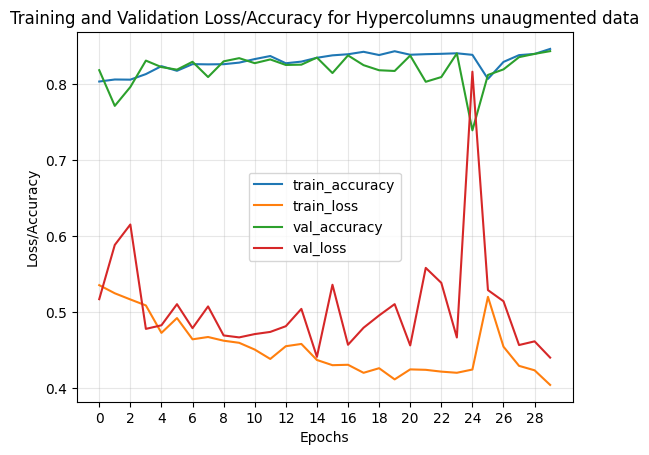

In [33]:
#Load in data
subfolder = "best_model_training_logs/unaugmented_data_perfomraces/"
metric_files = ['train_accuracies.txt', 'train_losses.txt', 'val_accuracies.txt', 'val_losses.txt']
metrics = []
for file in metric_files:
    metrics.append(load_data(subfolder + file))
names = ["train_accuracy", "train_loss", "val_accuracy", "val_loss"]
plot_training(metrics, names, 0, 'Training and Validation Loss/Accuracy for Hypercolumns unaugmented data', "Epochs", "Loss/Accuracy", 'plots/hypercol_training_baseline.png', have_grid = True)

### Augmented Data

#### Training

In [ ]:
# Define the UNetResNextHyperSE model
num_classes = 7  # number of segmentation labels
input_channels = 7  # Number of channels in the input data

# Instantiate the model
model = UNetResNextHyperSE(
    encoder_depth=50,  # Use SE-ResNeXt50 as the backbone
    num_classes=num_classes,
    num_filters=32,
    is_deconv=True,
    dropout_2d=0.2
)

# Transfer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model successfully instantiated and moved to:", device)

In [ ]:
#-------------augmented data----------------
# Create training and validation datasets, use: augmented train and validation data
train_dataset = SegmentationDataset(train_data, train_labels)
val_dataset = SegmentationDataset(val_data, val_labels)

# Create DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
#--------------------------------------------
print("DataLoader successfully created.")

In [ ]:
train_hypercol(model, train_loader, val_loader, "models/hypercol_aug_model.pth", "best_model_training_logs/augmented_data_performances/")
print("\nTraining complete!")

#### Evaluation

In [ ]:
evaluate_hypercol("models/hypercol_aug_model.pth", testimage_files, testlabel_files, device)

#### Plotting

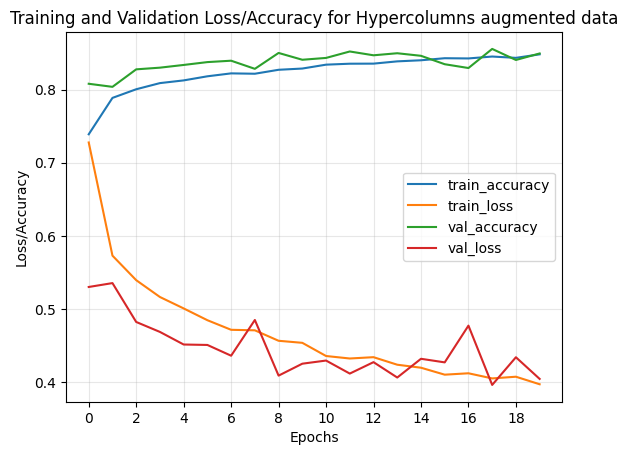

In [32]:
#Load in data
subfolder = "best_model_training_logs/augmented_data_performances/"
metric_files = ['train_accuracies.txt', 'train_losses.txt', 'val_accuracies.txt', 'val_losses.txt']
metrics = []
for file in metric_files:
    metrics.append(load_data(subfolder + file))
names = ["train_accuracy", "train_loss", "val_accuracy", "val_loss"]
plot_training(metrics, names, 0, 'Training and Validation Loss/Accuracy for Hypercolumns augmented data', "Epochs", "Loss/Accuracy", 'plots/hypercol_training_augmented.png', have_grid = True)

### All Data

#### Training

In [ ]:
# Define the UNetResNextHyperSE model
num_classes = 7  # number of segmentation labels
input_channels = 7  # Number of channels in the input data

# Instantiate the model
model = UNetResNextHyperSE(
    encoder_depth=50,  # Use SE-ResNeXt50 as the backbone
    num_classes=num_classes,
    num_filters=32,
    is_deconv=True,
    dropout_2d=0.2
)

# Transfer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model successfully instantiated and moved to:", device)

In [ ]:
#-------------all data----------------
# Create training and validation datasets, use: all data
train_dataset = SegmentationDataset(train_data_all_years, train_labels_all_years)
val_dataset = SegmentationDataset(val_data_all_years, val_labels_all_years)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
#--------------------------------------------
print("DataLoader successfully created.")

In [ ]:
train_hypercol(model, train_loader, val_loader, "models/hypercol_all_data_model.pth", "best_model_training_logs/augmented_data_performances/")
print("\nTraining complete!")

#### Evaluation

In [ ]:
evaluate_hypercol("models/hypercol_all_data_model.pth", testimage_files, testlabel_files, device)

#### Plotting

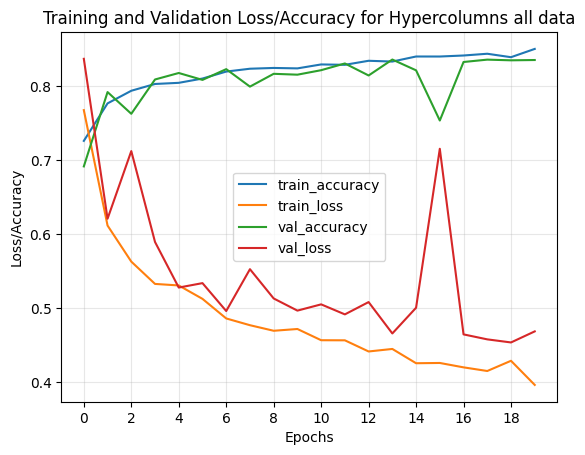

In [34]:
#Load in data
subfolder = "best_model_training_logs/all_data_performance/"
metric_files = ['train_accuracies.txt', 'train_losses.txt', 'val_accuracies.txt', 'val_losses.txt']
metrics = []
for file in metric_files:
    metrics.append(load_data(subfolder + file))
names = ["train_accuracy", "train_loss", "val_accuracy", "val_loss"]
plot_training(metrics, names, 0, 'Training and Validation Loss/Accuracy for Hypercolumns all data', "Epochs", "Loss/Accuracy", 'plots/hypercol_training_all_data.png', have_grid = True)